In [1]:
from SimEx.Calculators.GaussianPhotonSource import GaussianPhotonSource
from SimEx.Parameters.GaussWavefrontParameters import GaussWavefrontParameters

from wpg import Beamline
from wpg.optical_elements import Aperture, Drift, CRL, Empty, Use_PP

In [2]:
import copy
from wpg import wpg_uti_wf as wfutils

In [3]:
from wpg import Beamline, optical_elements, srwlib
from wpg.useful_code.wfrutils import propagate_wavefront

In [4]:
from SimEx.Utilities.Units import electronvolt, meter, joule, radian

In [5]:
#S1 beamline layout
### Geometry ###
src_to_hom1 = 257.8 # Distance source to HOM 1 [m]
src_to_hom2 = 267.8 # Distance source to HOM 2 [m]
src_to_crl = 887.8  # Distance source to CRL [m]
#     src_to_exp = 920.42 # Distance source to experiment [m]
z0 = src_to_hom1

In [6]:
# Drift to focus aperture
z = 34.0
#define distances, angles, etc
#...
#Incidence angle at HOM
theta_om = 3.6e-3       # [rad]

om_mirror_length = 0.8 # [m]
om_clear_ap = om_mirror_length*theta_om
print("Clear mirror aperture = {0:4.3e} m".format(om_clear_ap))

Clear mirror aperture = 2.880e-03 m


In [7]:
# Photon source
wavefront_parameters = GaussWavefrontParameters(photon_energy=8.0e3*electronvolt,
                                                photon_energy_relative_bandwidth=1e-3,
                                                beam_diameter_fwhm=1.0e-4*meter,
                                                pulse_energy=2.0e-6*joule,
                                                number_of_transverse_grid_points=200,
                                                number_of_time_slices=30,
                                                z = z0*meter,
                                                )
photon_source = GaussianPhotonSource(wavefront_parameters, input_path="/dev/null", output_path="initial_wavefront.h5")
photon_source.backengine()
photon_source.saveH5()

In [8]:
def fftprop(wavefront, beamline):
    srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 'f')
    propagate_wavefront(wavefront,beamline)
    srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 't')

In [9]:
def wfdiag(wf):
    wfutils.plot_intensity_map(wf)
    wfutils.plot_intensity_qmap(wf)
    print(wfutils.check_sampling(wf))

In [10]:
#define the beamline:
zoom=1

bl0 = Beamline()
# Define HOM1.
aperture_x_to_y_ratio = 1
hom1 = Aperture(shape='r',ap_or_ob='a',Dx=om_clear_ap,Dy=om_clear_ap/aperture_x_to_y_ratio)
bl0.append( hom1, Use_PP(semi_analytical_treatment=0, zoom=zoom, sampling=zoom) )

Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.00288
	Dy = 0.00288
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	

R-space
nx   200  range_x [-1.3e+00, 1.3e+00] mm
ny   200  range_y [-1.3e+00, 1.3e+00] mm
*****propagating wavefront (with resizing)...
done
R-space
(200,) (200,)
FWHM in x = 2.038e-04 m.
FWHM in y = 2.038e-04 m.


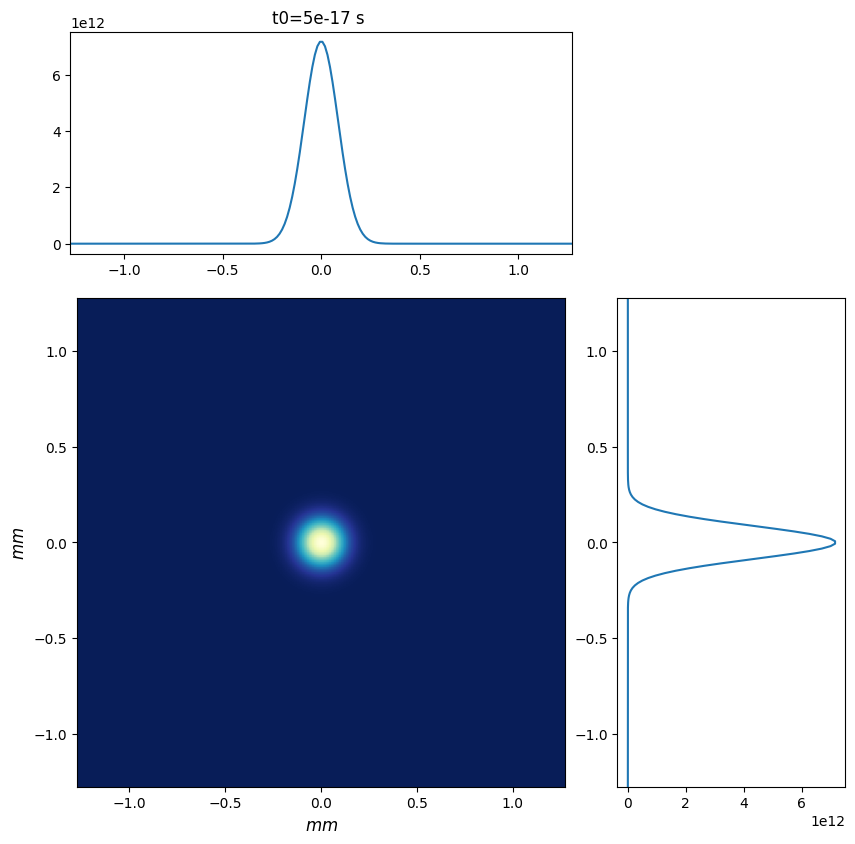

Q-space
{'fwhm_x': 6.623796255446273e-07, 'fwhm_y': 6.623796255446273e-07}
Q-space
(200,) (200,)


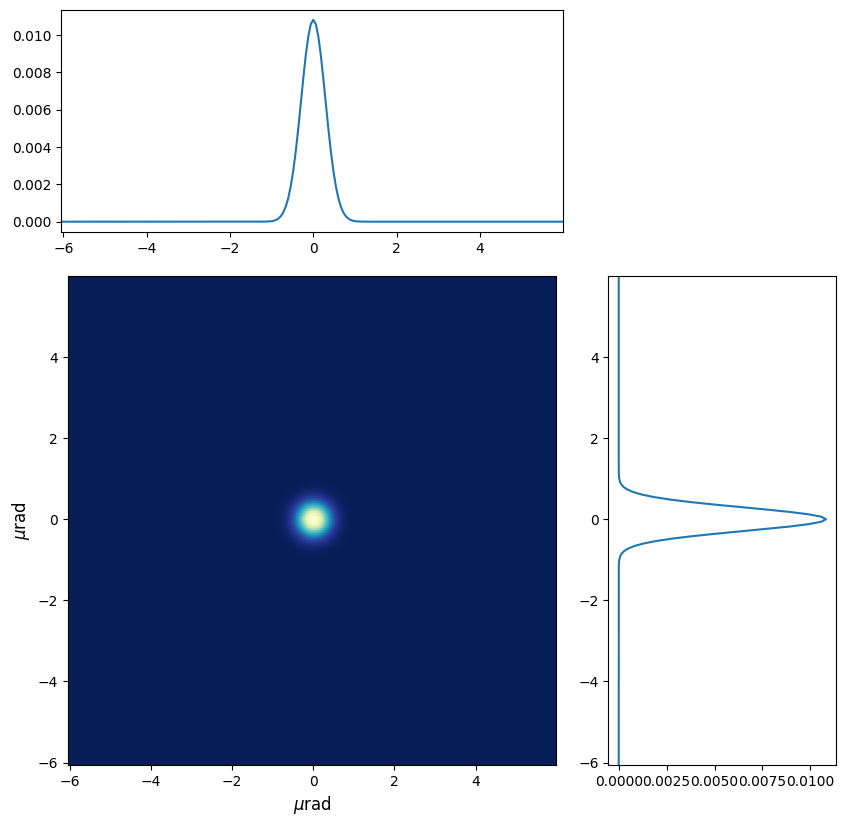

WAVEFRONT SAMPLING REPORT
+----------+---------+---------+---------+---------+---------+---------+---------+
|x/y       |FWHM     |px       |ROI      |R        |Fzone    |px*7     |px*10    |
+----------+---------+---------+---------+---------+---------+---------+---------+
|Horizontal|2.038e-04|1.280e-05|2.548e-03|2.964e+02|1.126e-04|8.963e-05|1.280e-04|
|Vertical  |2.038e-04|1.280e-05|2.548e-03|2.964e+02|1.126e-04|8.963e-05|1.280e-04|
+----------+---------+---------+---------+---------+---------+---------+---------+

Horizontal Fresnel zone extension within [7,10]*pixel_width -> OK
Vertical Fresnel zone extension within [7,10]*pixel_height -> OK
Horizontal ROI > 3* FWHM(x) -> OK
Horizontal ROI > 3* FWHM(y) -> OK
Focus sampling: FWHM > 10*px

END OF REPORT


In [11]:
wf0 = copy.deepcopy(photon_source.data)
fftprop(wf0, bl0)
wfdiag(wf0)

In [12]:
# Free space propagation from hom1 to hom2
hom1_to_hom2_drift = Drift(src_to_hom2 - src_to_hom1)
bl0.append( hom1_to_hom2_drift, Use_PP(semi_analytical_treatment=0))

#### Convert to code cell to propagate and diagnose wavefront at this point.
wf0 = copy.deepcopy(photon_source.data)
fftprop(wf0, bl0)
wfdiag(wf0)

In [13]:
# Define HOM2.
zoom = 1.0
hom2 = Aperture('r','a', om_clear_ap, om_clear_ap/aperture_x_to_y_ratio)
bl0.append( hom2,  Use_PP(semi_analytical_treatment=0, zoom=zoom, sampling=zoom/0.75))

#### Convert to code cell to propagate and diagnose wavefront at this point.
wf0 = copy.deepcopy(photon_source.data)
fftprop(wf0, bl0)
wfdiag(wf0)

In [14]:
#drift to CRL aperture
hom2_to_crl_drift = Drift( src_to_crl - src_to_hom2 )
#bl0.append( hom2_to_crl_drift, Use_PP(semi_analytical_treatment=0))
bl0.append( hom2_to_crl_drift, Use_PP(semi_analytical_treatment=1))

In [15]:
# Define CRL
crl_focussing_plane = 3 # Both horizontal and vertical.
crl_delta = 4.7177e-06 # Refractive index decrement (n = 1- delta - i*beta)
crl_attenuation_length  = 6.3e-3    # Attenuation length [m], Henke data.
crl_shape = 1         # Parabolic lenses
crl_aperture = 5.0e-3 # [m]
crl_curvature_radius = 5.8e-3 # [m]
crl_number_of_lenses = 19
crl_wall_thickness = 8.0e-5 # Thickness
crl_center_horizontal_coordinate = 0.0
crl_center_vertical_coordinate = 0.0
crl_initial_photon_energy = 7.98e3 # [eV]
crl_final_photon_energy = 8.02e3 # [eV]

crl = CRL( _foc_plane=crl_focussing_plane,
            _delta=crl_delta,
            _atten_len=crl_attenuation_length,
            _shape=crl_shape,
            _apert_h=crl_aperture,
            _apert_v=crl_aperture,
            _r_min=crl_curvature_radius,
            _n=crl_number_of_lenses,
            _wall_thick=crl_wall_thickness,
            _xc=crl_center_horizontal_coordinate,
            _yc=crl_center_vertical_coordinate,
            _void_cen_rad=None,
            _e_start=crl_initial_photon_energy,
            _e_fin=crl_final_photon_energy,
            )

Optical Element Setup: CRL Focal Length: 32.35296414510639 m


Set zoom factor

In [16]:
zoom=1.0

In [17]:
bl0.append( crl, Use_PP(semi_analytical_treatment=1, zoom=zoom, sampling=1.0) )

In [18]:
print(z0)

257.8


In [19]:
# Photon source
wavefront_parameters = GaussWavefrontParameters(photon_energy=8.0e3*electronvolt,
                                                photon_energy_relative_bandwidth=1e-3,
                                                beam_diameter_fwhm=1.0e-4*meter,
                                                pulse_energy=2.0e-6*joule,
                                                number_of_transverse_grid_points=400,
                                                number_of_time_slices=30,
                                                z = z0*meter,
                                                )
photon_source = GaussianPhotonSource(wavefront_parameters, input_path="/dev/null", output_path="initial_wavefront.h5")
photon_source.backengine()
photon_source.saveH5()

#### Convert to code cell to propagate and diagnose wavefront at this point.
wf0 = photon_source.data
fftprop(wf0, bl0)
wfdiag(wf0)

In [20]:
crl_to_exp_drift = Drift( z )
bl0.append( crl_to_exp_drift, Use_PP(semi_analytical_treatment=1, zoom=1, sampling=1))

Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.00288
	Dy = 0.00288
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 10.0
	treat = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.3333333333333333, 1.0, 1.3333333333333333, 0, 0, 0]
	Dx = 0.00288
	Dy = 0.00288
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 620.0
	treat = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 32.35296414510639
	Fy = 32.35296414510639
	arTr = array of size 2004002
	extTr = 1
	input_parms = {'type': 'crl', 'focalPlane': 3, 'refractiveIndex': 4.7177e-06, 'attenuationLength': 0.0063, 'shape': 1, 'horizontalApertureSize': 0.005, 'verticalApertureSize': 0.005, 'radius': 

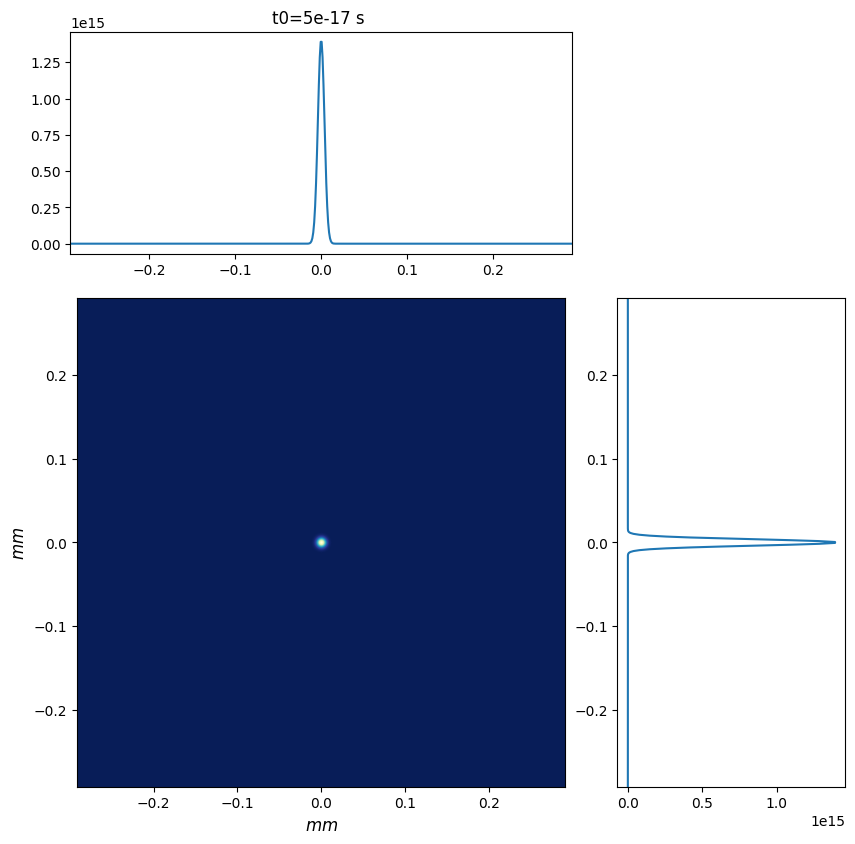

Q-space
{'fwhm_x': 1.7742974615496852e-05, 'fwhm_y': 1.7742974615496852e-05}
Q-space
(540,) (540,)


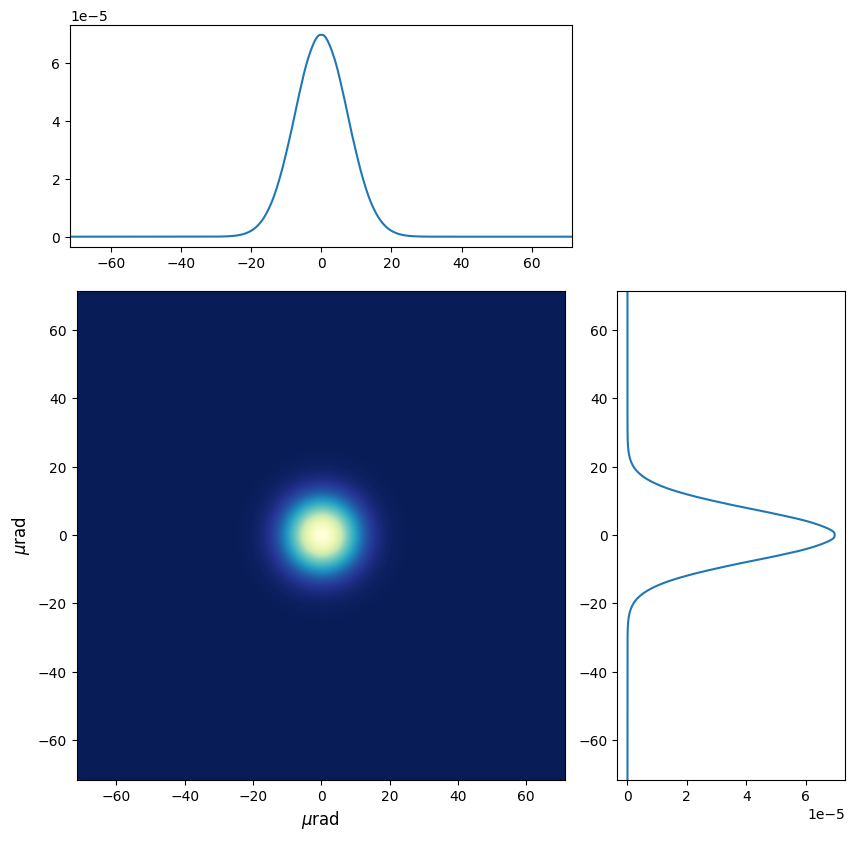

WAVEFRONT SAMPLING REPORT
+----------+---------+---------+---------+---------+---------+---------+---------+
|x/y       |FWHM     |px       |ROI      |R        |Fzone    |px*7     |px*10    |
+----------+---------+---------+---------+---------+---------+---------+---------+
|Horizontal|8.638e-06|1.082e-06|5.830e-04|4.763e-01|4.270e-06|7.572e-06|1.082e-05|
|Vertical  |8.638e-06|1.082e-06|5.830e-04|4.763e-01|4.270e-06|7.572e-06|1.082e-05|
+----------+---------+---------+---------+---------+---------+---------+---------+

Horizontal Fresnel zone extension NOT within [7,10]*pixel_width -> Check pixel width."
Vertical Fresnel zone extension NOT within [7,10]*pixel_height -> Check pixel width."
Horizontal ROI > 3* FWHM(x) -> OK
Horizontal ROI > 3* FWHM(y) -> OK
Focus sampling: FWHM > 10*px

END OF REPORT


In [21]:
wf0 = photon_source.data
fftprop(wf0, bl0)
wfdiag(wf0)